In [ ]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
import cv2
import glob

In [ ]:
#Mount Google Drive code. Can be mounted directly otherwise this code can be used 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from numpy import expand_dims
from matplotlib import pyplot

In [ ]:
# Uploading 'annotation_data.xlsx' file in Googl colab. We need to upload it for every session of Google colab
upload = files.upload()

Saving annotation_data.xlsx to annotation_data (2).xlsx


In [ ]:
# Reading annotations of AML data from https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=61080958
import pandas as pd
df = pd.read_excel('/content/annotation_data.xlsx', header = 0)

In [ ]:
print(df.head(3))

                File group annot reannot
0  BAS/BAS_0001.tiff   BAS   NaN     NaN
1  BAS/BAS_0002.tiff   BAS   NaN     NaN
2  BAS/BAS_0003.tiff   BAS   NaN     NaN


In [ ]:
# We selected reannotated images with reannotated labels as MON, 'MYO' and 'PMO'
options = ['MON','MYO','PMO']
new_df = df[df['reannot'].isin(options)]

In [ ]:
print(new_df.describe()) # There are total 786 samples with reannotations: MON, 'MYO' and 'PMO'

                     File group annot reannot
count                 786   786   786     786
unique                786    10     7       3
top     LYA/LYA_0004.tiff   MYO   MYO     MYO
freq                    1   545   585     582


In [ ]:
print(new_df.head(130)) # Among 786 AML data we randomle selected 130 images as AML data and stored in folder

                   File group annot reannot
599   LYA/LYA_0004.tiff   LYA   MYO     MYO
601   LYA/LYA_0006.tiff   LYA   MYO     MYO
633   LYT/LYT_0027.tiff   LYT   MYO     MYO
1536  LYT/LYT_0930.tiff   LYT   MYO     MYO
1675  LYT/LYT_1069.tiff   LYT   MYO     MYO
...                 ...   ...   ...     ...
5596  MON/MON_1012.tiff   MON   MON     MON
5603  MON/MON_1019.tiff   MON   MON     MON
5617  MON/MON_1033.tiff   MON   MYO     MON
5621  MON/MON_1037.tiff   MON   MON     MON
5642  MON/MON_1058.tiff   MON   MON     MON

[130 rows x 4 columns]


Reading ALL, AML and Healthy images from the respective folders

In [ ]:
# Reading file paths of original ALL, AML and Healthy images in filenames1, filenames2 and filenames3 respectively
filenames1 = [img for img in glob.glob("/content/drive/MyDrive/Data/Test_original/ALL/*.tif")] 
filenames2 = [img for img in glob.glob("/content/drive/MyDrive/Data/Test_original/AML/*.tiff")]
filenames3 = [img for img in glob.glob("/content/drive/MyDrive/Data/Test_original/Healthy/*.tif")]

In [ ]:
print(filenames1)

['/content/drive/MyDrive/Data/Test_original/ALL/Im025_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im033_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im005_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im002_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im004_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im008_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im027_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im006_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im013_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im014_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im022_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im023_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im001_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im015_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im011_1.tif', '/content/drive/MyDrive/Data/Test_original/ALL/Im003_1.tif', '/content/drive/MyDrive

In [ ]:
# Function for reading files from paths in different filenames
def read(im, file):
  for image in file:
    im.append(cv2.imread(image))


In [ ]:
# Reading original 130 ALL data images in images_all
images_all = []
read(images_all, filenames1)
"""for image in filenames1:
    images_all.append(cv2.imread(image))"""

'for image in filenames1:\n    images_all.append(cv2.imread(image))'

In [ ]:
# Reading original 130 AML data images in images_aml
images_aml = []
read(images_aml, filenames2)

In [ ]:
print(len(images_aml))
print(images_aml[3].shape) # The size of original AML data images is large (400X400) as compared to ALL and Healthy images(257X257) 

130
(400, 400, 3)


In [ ]:
# AML images are of size 400X400 and ALL,Healthy images are of size 257X257
# Resizing AML images from 400X400 to 257X257
img_aml = []

for i in range(0, 130):
    img_aml.append(cv2.resize(images_aml[i], (257,257)))

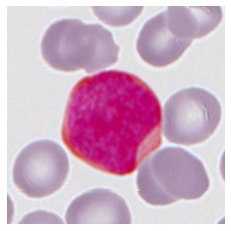

In [ ]:
# Checking display of one image after reducing size if image is visibly clear or not
plt.imshow(img_aml[3])
plt.axis('off')
plt.show()

In [ ]:
print(images_aml[1].shape)
print(img_aml[3].shape)
# AML image size is reduced to 257X257

(400, 400, 3)
(257, 257, 3)


In [ ]:
# Reading original healthy images in images_hlty
images_hlty = []
read(images_hlty, filenames3)

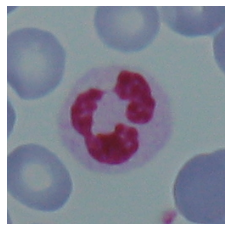

In [ ]:
# Displaying one image of healthy
plt.imshow(images_hlty[3])
plt.axis('off')
plt.show()

In [ ]:
print(len(images_hlty))
print(images_hlty[3].shape)

130
(257, 257, 3)


In [ ]:
# Creating an object of ImageDataGenerator() for augmentation
# Augmentation: Rotation, height and width shift, rescaling, shearing, zooming, horizontal flip
datagen = ImageDataGenerator(rotation_range=90,height_shift_range=0.2,width_shift_range=0.2,rescale=1./255,shear_range=0.3,zoom_range=0.3, horizontal_flip=True)

#it = datagen.flow(images_all, batch_size = 1) # The data generator itself is in fact an iterator, returning batches of image samples when requested. We can configure the batch size and prepare the data generator and get batches of images by calling the flow() function.

In [ ]:
# ALL
# Creating augmented images of ALL data in folder ALL under Augmented folder
for img in images_all:
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape)

  i = 0
  for batch in datagen.flow (x, batch_size=1, save_to_dir =r'/content/drive/MyDrive/Data/Augment/ALL', save_prefix ='aug', save_format='jpg'):
    i+=1
    if i>8:   # here we fix a range otherwise loop will go forever and we want 8 augmented images
      break

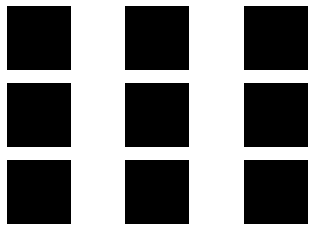

In [ ]:
# Displaying augmented images
gen=ImageDataGenerator(rotation_range=60)

for i in range(9):
    pyplot.subplot(330+1+i)
    #batch = it.next()
    image = batch[0].astype('uint8')
    pyplot.imshow(image)
    plt.axis('off')
pyplot.show()

In [ ]:
# AML
# Creating augmented images of AML data in folder AML under Augmented folder. We used AML images in img_aml which are already resized to 257X257.
for img in img_aml:
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape)

  i = 0
  for batch in datagen.flow (x, batch_size=1, save_to_dir =r'/content/drive/MyDrive/Data/Augment/AML', save_prefix ='aug', save_format='jpg'):
    i+=1
    if i>8:
      break

In [ ]:
# Healthy
# Creating augmented images of Healthy data in folder Healthy under Augmented folder
for img in images_hlty:
  x = img_to_array(img)
  x = x.reshape((1,) + x.shape)

  i = 0
  for batch in datagen.flow (x, batch_size=1, save_to_dir =r'//content/drive/MyDrive/Data/Augment/Healthy', save_prefix ='aug', save_format='jpg'):
    i+=1
    if i>8:
      break